# SD-Face-Editor Jupyter Notebook Demo

The original repository (https://github.com/ototadana/sd-face-editor) is based on stable-diffusion-webui. This notebook aims to reimplement the key components without webui's APIs.

## How it works
This script performs the following steps:

### Step 0
First, image(s) are generated as usual according to prompts and other settings. This script acts as a post-processor for those images.

### Step 1. Face Detection
Detects faces on the image.

### Step 2. Crop and Resize the Faces
Crop the detected face image and resize it to 512x512.

### Step 3. Recreate the Faces
Run img2img with the image to create a new face image.

### Step 4. Paste the Faces
Resize the new face image and paste it at the original image location.

### Step 5. Blend the entire image
To remove the borders generated when pasting the image, mask all but the face and run inpaint.

In [82]:
# Global variables
device = "cuda"
seed = 1234

In [2]:
import torch
from facexlib.detection import init_detection_model, retinaface
from PIL import Image, ImageOps, ImageDraw
import PIL
import numpy as np
import cv2

from abc import ABC, abstractmethod
from typing import List
from typing import Dict, NamedTuple, Tuple

from diffusers import (
    AutoencoderKL, 
    UNet2DConditionModel, 
    LMSDiscreteScheduler, 
    DDIMScheduler,  
    StableDiffusionImg2ImgPipeline,
)

from transformers import CLIPTextModel, CLIPTokenizer

from facexlib.parsing import init_parsing_model
from facexlib.utils.misc import img2tensor
from torchvision.transforms.functional import normalize

from operator import attrgetter

In [3]:
class Point(NamedTuple):
    x: int
    y: int


class Landmarks(NamedTuple):
    eye1: Point
    eye2: Point
    nose: Point
    mouth1: Point
    mouth2: Point

In [4]:
class Rect:
    def __init__(
        self,
        left: int,
        top: int,
        right: int,
        bottom: int,
        tag: str = "face",
        landmarks: Landmarks = None,
        attributes: Dict[str, str] = {},
    ) -> None:
        self.tag = tag
        self.left = left
        self.top = top
        self.right = right
        self.bottom = bottom
        self.center = int((right + left) / 2)
        self.middle = int((top + bottom) / 2)
        self.width = right - left
        self.height = bottom - top
        self.size = self.width * self.height
        self.landmarks = landmarks
        self.attributes = attributes

    @classmethod
    def from_ndarray(
        cls,
        face_box: np.ndarray,
        tag: str = "face",
        landmarks: Landmarks = None,
        attributes: Dict[str, str] = {},
    ) -> "Rect":
        left, top, right, bottom, *_ = list(map(int, face_box))
        return cls(left, top, right, bottom, tag, landmarks, attributes)

    def to_tuple(self) -> Tuple[int, int, int, int]:
        return self.left, self.top, self.right, self.bottom

    def to_square(self):
        left, top, right, bottom = self.to_tuple()

        width = right - left
        height = bottom - top

        if width % 2 == 1:
            right = right + 1
            width = width + 1
        if height % 2 == 1:
            bottom = bottom + 1
            height = height + 1

        diff = int(abs(width - height) / 2)
        if width > height:
            top = top - diff
            bottom = bottom + diff
        else:
            left = left - diff
            right = right + diff

        return left, top, right, bottom


In [5]:
class Option:
    DEFAULT_FACE_MARGIN = 1.6
    DEFAULT_CONFIDENCE = 0.97
    DEFAULT_STRENGTH1 = 0.4
    DEFAULT_STRENGTH2 = 0.0
    DEFAULT_MAX_FACE_COUNT = 20
    DEFAULT_MASK_SIZE = 0
    DEFAULT_MASK_BLUR = 12
    DEFAULT_PROMPT_FOR_FACE = "hyperdetailed, masterpiece, top quality, best quality, official art, beautiful and aesthetic, colorful,highest detailed"
    DEFAULT_NEGATIVE_PROMPT_FOR_FACE = "bad_pictures,disfigured,lowres,cross-eyed,missing fingers,fused fingers,too many fingers,poorly drawn hands,malformed limbs,missing limb,mutated hands,ugly,long body,bad body,mutated,deformed,disconnected limbs,malformed hands,extra legs,bad feet,mutated hands and fingers,bad hands,extra limb,extra arms,floating limbs,poorly drawn face,skin blemishes,skin spots,mutation,long neck,mole,scar"
    DEFAULT_APPLY_INSIDE_MASK_ONLY = True
    DEFAULT_SAVE_ORIGINAL_IMAGE = False
    DEFAULT_SHOW_ORIGINAL_IMAGE = False
    DEFAULT_SHOW_INTERMEDIATE_STEPS = False
    DEFAULT_APPLY_SCRIPTS_TO_FACES = False
    DEFAULT_FACE_SIZE = 512
    DEFAULT_USE_MINIMAL_AREA = False
    DEFAULT_IGNORE_LARGER_FACES = True
    DEFAULT_AFFECTED_AREAS = ["Face"]
    # DEFAULT_WORKFLOW = open(os.path.join(workflows_dir, "default.json")).read()
    DEFAULT_UPSCALER = "None"
    DEFAULT_TILT_ADJUSTMENT_THRESHOLD = 40

    def __init__(self, *args) -> None:
        self.extra_options: Dict[str, Dict[str, str]] = {}
        self.face_margin = Option.DEFAULT_FACE_MARGIN
        self.confidence = Option.DEFAULT_CONFIDENCE
        self.strength1 = Option.DEFAULT_STRENGTH1
        self.strength2 = Option.DEFAULT_STRENGTH2
        self.max_face_count = Option.DEFAULT_MAX_FACE_COUNT
        self.mask_size = Option.DEFAULT_MASK_SIZE
        self.mask_blur = Option.DEFAULT_MASK_BLUR
        self.prompt_for_face = Option.DEFAULT_PROMPT_FOR_FACE
        self.negative_prompt_for_face = Option.DEFAULT_NEGATIVE_PROMPT_FOR_FACE
        self.apply_inside_mask_only = Option.DEFAULT_APPLY_INSIDE_MASK_ONLY
        self.save_original_image = Option.DEFAULT_SAVE_ORIGINAL_IMAGE
        self.show_intermediate_steps = Option.DEFAULT_SHOW_INTERMEDIATE_STEPS
        self.apply_scripts_to_faces = Option.DEFAULT_APPLY_SCRIPTS_TO_FACES
        self.face_size = Option.DEFAULT_FACE_SIZE
        self.use_minimal_area = Option.DEFAULT_USE_MINIMAL_AREA
        self.ignore_larger_faces = Option.DEFAULT_IGNORE_LARGER_FACES
        self.affected_areas = Option.DEFAULT_AFFECTED_AREAS
        self.show_original_image = Option.DEFAULT_SHOW_ORIGINAL_IMAGE
        # self.workflow = Option.DEFAULT_WORKFLOW
        self.upscaler = Option.DEFAULT_UPSCALER
        self.tilt_adjustment_threshold = Option.DEFAULT_TILT_ADJUSTMENT_THRESHOLD

        # if len(args) > 0 and isinstance(args[0], dict):
        #     self.update_by_dict(args[0])
        # else:
        #     self.update_by_list(args)

        self.apply_scripts_to_faces = False
        self.correct_tilt = False

        self.mask_round = True
option = Option()

In [6]:
def rotate_image(image: Image, angle: float) -> Image:
    if angle == 0:
        return image
    return Image.fromarray(rotate_array(np.array(image), angle))


def rotate_array(image: np.ndarray, angle: float) -> np.ndarray:
    if angle == 0:
        return image

    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

In [7]:
def correct_tilt_func(option: Option, angle: float) -> bool:
        if option.correct_tilt:
            return True
        angle = abs(angle)
        if angle > 180:
            angle = 360 - angle
        return angle > option.tilt_adjustment_threshold

In [8]:
def resize_image(resize_mode, im, width, height, upscaler_name=None):
    """
    Resizes an image with the specified resize_mode, width, and height.

    Args:
        resize_mode: The mode to use when resizing the image.
            0: Resize the image to the specified width and height.
            1: Resize the image to fill the specified width and height, maintaining the aspect ratio, and then center the image within the dimensions, cropping the excess.
            2: Resize the image to fit within the specified width and height, maintaining the aspect ratio, and then center the image within the dimensions, filling empty with data from image.
        im: The image to resize.
        width: The width to resize the image to.
        height: The height to resize the image to.
        upscaler_name: The name of the upscaler to use. If not provided, defaults to opts.upscaler_for_img2img.
    """

    # upscaler_name = upscaler_name or opts.upscaler_for_img2img

    # def resize(im, w, h):
    #     if upscaler_name is None or upscaler_name == "None" or im.mode == 'L':
    #         return im.resize((w, h), resample=LANCZOS)

    #     scale = max(w / im.width, h / im.height)

    #     if scale > 1.0:
    #         upscalers = [x for x in shared.sd_upscalers if x.name == upscaler_name]
    #         if len(upscalers) == 0:
    #             upscaler = shared.sd_upscalers[0]
    #             print(f"could not find upscaler named {upscaler_name or '<empty string>'}, using {upscaler.name} as a fallback")
    #         else:
    #             upscaler = upscalers[0]

    #         im = upscaler.scaler.upscale(im, scale, upscaler.data_path)

    #     if im.width != w or im.height != h:
    #         im = im.resize((w, h), resample=LANCZOS)

    #     return im

    def resize(im, w, h):
        return im.resize((w,h))

    if resize_mode == 0:
        res = resize(im, width, height)

    elif resize_mode == 1:
        ratio = width / height
        src_ratio = im.width / im.height

        src_w = width if ratio > src_ratio else im.width * height // im.height
        src_h = height if ratio <= src_ratio else im.height * width // im.width

        resized = resize(im, src_w, src_h)
        res = Image.new("RGB", (width, height))
        res.paste(resized, box=(width // 2 - src_w // 2, height // 2 - src_h // 2))

    else:
        ratio = width / height
        src_ratio = im.width / im.height

        src_w = width if ratio < src_ratio else im.width * height // im.height
        src_h = height if ratio >= src_ratio else im.height * width // im.width

        resized = resize(im, src_w, src_h)
        res = Image.new("RGB", (width, height))
        res.paste(resized, box=(width // 2 - src_w // 2, height // 2 - src_h // 2))

        if ratio < src_ratio:
            fill_height = height // 2 - src_h // 2
            if fill_height > 0:
                res.paste(resized.resize((width, fill_height), box=(0, 0, width, 0)), box=(0, 0))
                res.paste(resized.resize((width, fill_height), box=(0, resized.height, width, resized.height)), box=(0, fill_height + src_h))
        elif ratio > src_ratio:
            fill_width = width // 2 - src_w // 2
            if fill_width > 0:
                res.paste(resized.resize((fill_width, height), box=(0, 0, 0, height)), box=(0, 0))
                res.paste(resized.resize((fill_width, height), box=(resized.width, 0, resized.width, height)), box=(fill_width + src_w, 0))

    return res

In [84]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Step 0 Load the initial image

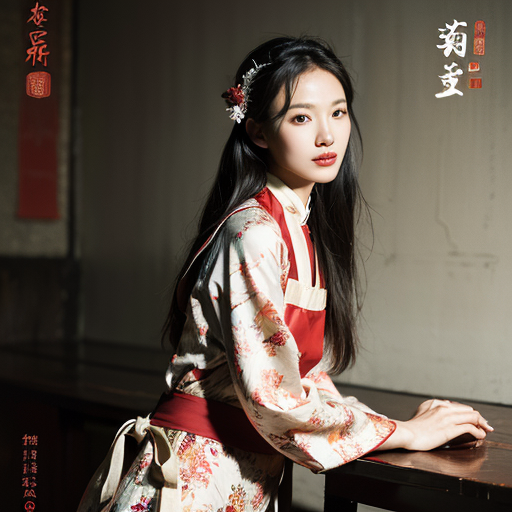

In [9]:
# read image prompt (face, here we use a ai-generation face)
image = Image.open(f"assets/girl2.png")

# image.resize((256, 256))
image0 = image.copy()
imagenp = np.array(image)
image

## Step 1. Face Detection

In [10]:
class Face:
    def __init__(self, entire_image: np.ndarray, face_area: Rect, face_margin: float, face_size: int, upscaler: str):
        self.face_area = face_area
        self.center = face_area.center
        left, top, right, bottom = face_area.to_square()
        self.left, self.top, self.right, self.bottom = self.__ensure_margin(
            left, top, right, bottom, entire_image, face_margin
        )

        self.width = self.right - self.left
        self.height = self.bottom - self.top

        self.image = self.__crop_face_image(entire_image, face_size, upscaler)
        self.face_size = face_size
        self.scale_factor = face_size / self.width
        self.face_area_on_image = self.__get_face_area_on_image()
        self.landmarks_on_image = self.__get_landmarks_on_image()

    def __get_face_area_on_image(self):
        left = int((self.face_area.left - self.left) * self.scale_factor)
        top = int((self.face_area.top - self.top) * self.scale_factor)
        right = int((self.face_area.right - self.left) * self.scale_factor)
        bottom = int((self.face_area.bottom - self.top) * self.scale_factor)
        return self.__clip_values(left, top, right, bottom)

    def __get_landmarks_on_image(self):
        landmarks = []
        if self.face_area.landmarks is not None:
            for landmark in self.face_area.landmarks:
                landmarks.append(
                    Point(
                        int((landmark.x - self.left) * self.scale_factor),
                        int((landmark.y - self.top) * self.scale_factor),
                    )
                )
        return landmarks

    def __crop_face_image(self, entire_image: np.ndarray, face_size: int, upscaler: str):
        cropped = entire_image[self.top : self.bottom, self.left : self.right, :]
        if upscaler and upscaler != Option.DEFAULT_UPSCALER:
            return images.resize_image(0, Image.fromarray(cropped), face_size, face_size, upscaler)
        else:
            return Image.fromarray(cv2.resize(cropped, dsize=(face_size, face_size)))

    def __ensure_margin(self, left: int, top: int, right: int, bottom: int, entire_image: np.ndarray, margin: float):
        entire_height, entire_width = entire_image.shape[:2]

        side_length = right - left
        margin = min(min(entire_height, entire_width) / side_length, margin)
        diff = int((side_length * margin - side_length) / 2)

        top = top - diff
        bottom = bottom + diff
        left = left - diff
        right = right + diff

        if top < 0:
            bottom = bottom - top
            top = 0
        if left < 0:
            right = right - left
            left = 0

        if bottom > entire_height:
            top = top - (bottom - entire_height)
            bottom = entire_height
        if right > entire_width:
            left = left - (right - entire_width)
            right = entire_width

        return left, top, right, bottom

    def get_angle(self) -> float:
        landmarks = getattr(self.face_area, "landmarks", None)
        if landmarks is None:
            return 0

        eye1 = getattr(landmarks, "eye1", None)
        eye2 = getattr(landmarks, "eye2", None)
        if eye2 is None or eye1 is None:
            return 0

        try:
            dx = eye2.x - eye1.x
            dy = eye2.y - eye1.y
            if dx == 0:
                dx = 1
            angle = np.arctan(dy / dx) * 180 / np.pi

            if dx < 0:
                angle = (angle + 180) % 360
            return angle
        except Exception:
            print(traceback.format_exc())
            return 0

    def rotate_face_area_on_image(self, angle: float):
        center = [
            (self.face_area_on_image[0] + self.face_area_on_image[2]) / 2,
            (self.face_area_on_image[1] + self.face_area_on_image[3]) / 2,
        ]

        points = [
            [self.face_area_on_image[0], self.face_area_on_image[1]],
            [self.face_area_on_image[2], self.face_area_on_image[3]],
        ]

        angle = np.radians(angle)
        rot_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])

        points = np.array(points) - center
        points = np.dot(points, rot_matrix.T)
        points += center
        left, top, right, bottom = (int(points[0][0]), int(points[0][1]), int(points[1][0]), int(points[1][1]))

        left, right = (right, left) if left > right else (left, right)
        top, bottom = (bottom, top) if top > bottom else (top, bottom)

        width, height = right - left, bottom - top
        if width < height:
            left, right = left - (height - width) // 2, right + (height - width) // 2
        elif height < width:
            top, bottom = top - (width - height) // 2, bottom + (width - height) // 2
        return self.__clip_values(left, top, right, bottom)

    def __clip_values(self, *args):
        result = []
        for val in args:
            if val < 0:
                result.append(0)
            elif val > self.face_size:
                result.append(self.face_size)
            else:
                result.append(val)
        return tuple(result)


In [11]:
class RetinafaceDetector:
    def __init__(self) -> None:
        self.detection_model = init_detection_model("retinaface_resnet50", device=device)

    def name(self):
        return "RetinaFace"

    def detect_faces(self, image: Image, confidence: float, **kwargs) -> List[Rect]:
        with torch.no_grad():
            boxes_landmarks = self.detection_model.detect_faces(image, confidence)

        faces = []
        for box_landmark in boxes_landmarks:  
            face_box = box_landmark[:5] # left, top, right, bottom, *_
            landmark = box_landmark[5:]

            face = Rect.from_ndarray(face_box)

            eye1 = Point(int(landmark[0]), int(landmark[1]))
            eye2 = Point(int(landmark[2]), int(landmark[3]))
            nose = Point(int(landmark[4]), int(landmark[5]))
            mouth2 = Point(int(landmark[6]), int(landmark[7]))
            mouth1 = Point(int(landmark[8]), int(landmark[9]))

            face.landmarks = Landmarks(eye1, eye2, nose, mouth1, mouth2)
            faces.append(face)

        return faces

In [12]:
retinaFaceDetector = RetinafaceDetector()

/ssddata/liuyue/miniconda3/envs/diffusers/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/ssddata/liuyue/miniconda3/envs/diffusers/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
faces_raw = retinaFaceDetector.detect_faces(image, 0.9)

In [14]:
print(f"Totally {len(faces_raw)} faces in the image")

Totally 1 faces in the image


In [15]:
face_raw = faces_raw[0]

In [16]:
face_raw.landmarks

Landmarks(eye1=Point(x=301, y=120), eye2=Point(x=338, y=113), nose=Point(x=328, y=139), mouth1=Point(x=337, y=154), mouth2=Point(x=310, y=159))

In [17]:
print(face_raw.left, face_raw.top, face_raw.right, face_raw.bottom)

268 62 350 180


## Step 2. Crop and Resize the Leftmost Face

In [18]:
faces = []
for face_raw in faces_raw:
    face_area = face_raw
    face = Face(np.array(image), face_area, option.face_margin, option.face_size, option.upscaler)
    faces.append(face)
faces = sorted(faces, key=attrgetter("center"))

In [19]:
face = faces[0] # only consider the leftmost face

In [20]:
face.face_area_on_image

(144, 95, 367, 416)

In [21]:
face.landmarks_on_image

[Point(x=234, y=253),
 Point(x=334, y=234),
 Point(x=307, y=305),
 Point(x=332, y=345),
 Point(x=258, y=359)]

In [22]:
def draw_box(image, x1, y1, x2, y2):
    draw = ImageDraw.Draw(image)
    draw.rectangle([x1,y1,x2,y2], fill=None, outline="purple", width=5)
def draw_box_area(image, face_area):
    draw = ImageDraw.Draw(image)
    draw.rectangle(face_area, fill=None, outline="purple", width=5)

In [23]:
image_box = face.image.copy()
draw_box_area(image_box, face.face_area_on_image)

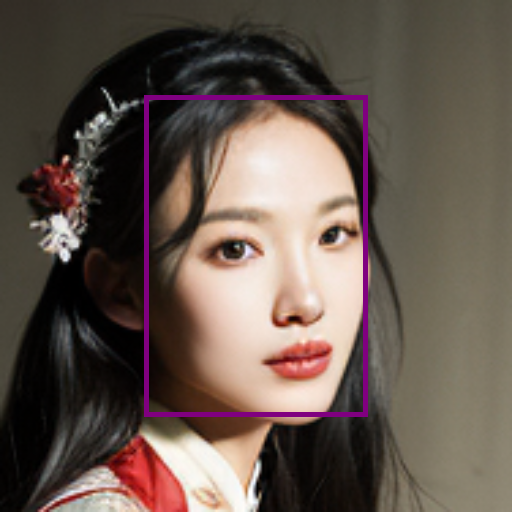

In [24]:
image_box

In [25]:
def draw_keypoints(image, points, radius=10):
    """
    points = [(x1,y1),(x2,y2),...]
    """
    draw = ImageDraw.Draw(image)

    for pt in points:
        x, y = pt
        draw.ellipse((x-radius, y-radius, x+radius, y+radius), fill="purple")

In [26]:
image_kps = face.image.copy()
draw_keypoints(image_kps, face.landmarks_on_image)

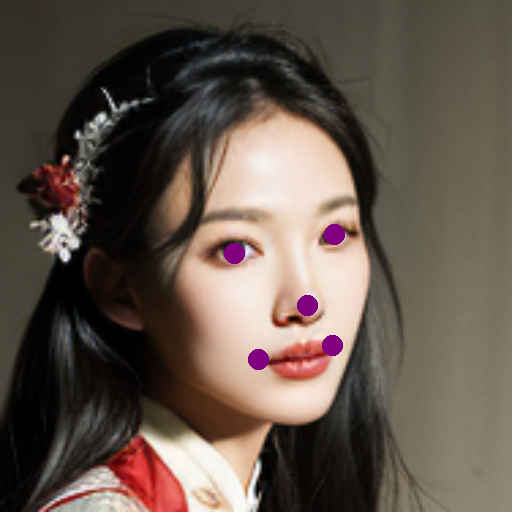

In [27]:
image_kps

In [28]:
face_image = face.image

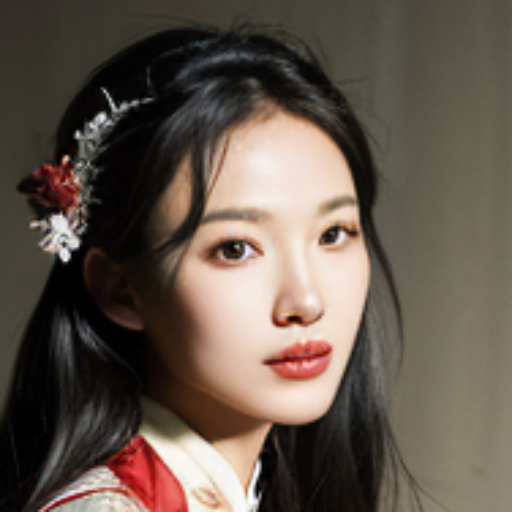

In [29]:
face_image

In [30]:
face_imagenp = np.array(face_image)

-10.713123022791034


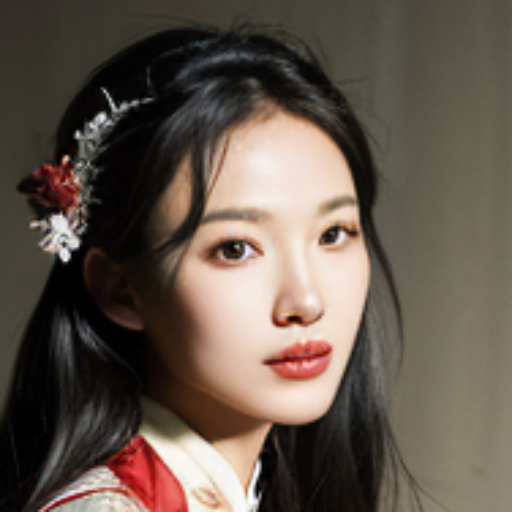

In [31]:
angle = face.get_angle()
print(angle)
correct_tilt = correct_tilt_func(option, angle)
face.image = rotate_image(face.image, angle) if correct_tilt else face.image
face.image

## Step 3. Recreate the Face

In [32]:
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"

In [33]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

In [34]:
# load SD pipeline
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
).to(device) # Need to put on GPU to support float16

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/ssddata/liuyue/github/diffusers/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:750: FutureWarning: You have passed 4 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/24 [00:00<?, ?it/s]

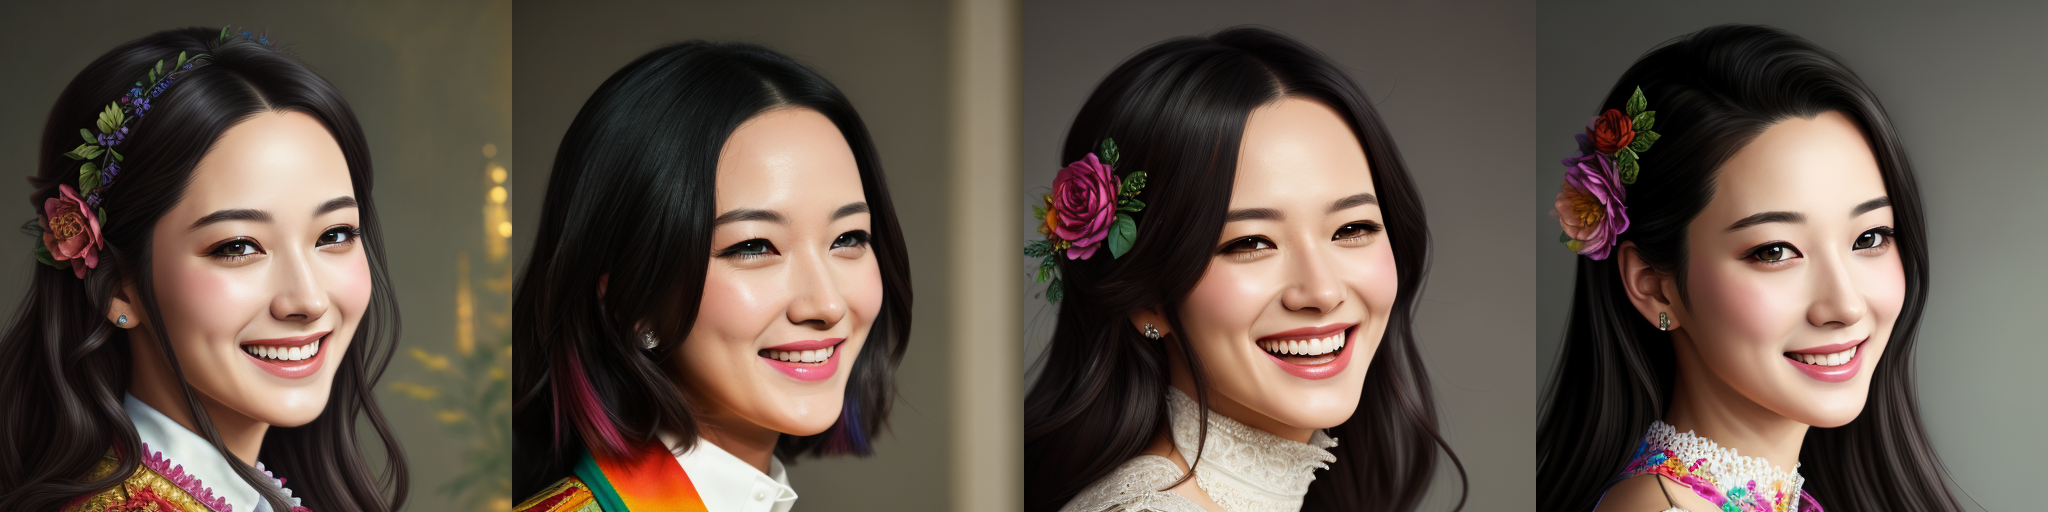

In [35]:
# NOT use ip-adapter to keep faceid
images = pipe(
    prompt=["laughing, " + option.prompt_for_face]*4, image=face_image,
    negative_prompt=[option.negative_prompt_for_face]*4, 
    scale=0.7, width=512, height=512, num_inference_steps=30, seed=seed, 
).images
grid = image_grid(images, 1, len(images))
grid

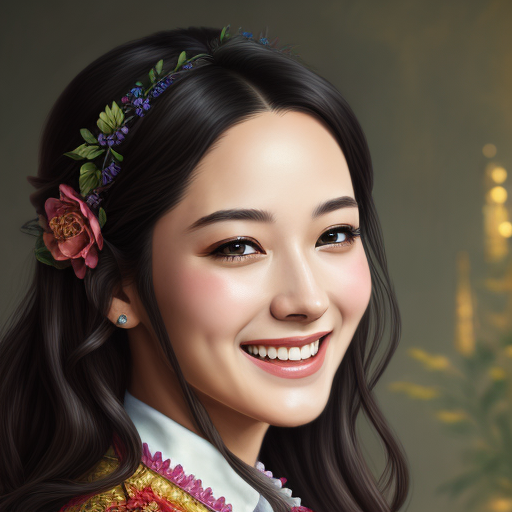

In [36]:
edited_face_image = images[0]
edited_face_image

In [37]:
edited_face_imagenp = np.array(edited_face_image)

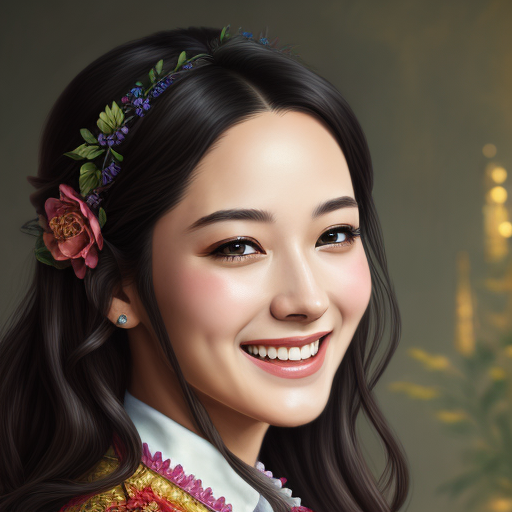

In [38]:
face.image = rotate_image(edited_face_image, -angle) if correct_tilt else edited_face_image
face.image

## Step 4. Paste the Face

In [39]:
class MaskGenerator(ABC):
    @abstractmethod
    def name(self) -> str:
        pass

    @abstractmethod
    def generate_mask(
        self,
        face_image: np.ndarray,
        face_area_on_image: Tuple[int, int, int, int],
        **kwargs,
    ) -> np.ndarray:
        pass

    @staticmethod
    def mask_non_face_areas(image: np.ndarray, face_area_on_image: Tuple[int, int, int, int]) -> np.ndarray:
        left, top, right, bottom = face_area_on_image
        image = image.copy()
        image[:top, :] = 0
        image[bottom:, :] = 0
        image[:, :left] = 0
        image[:, right:] = 0
        return image

    @staticmethod
    def calculate_mask_coverage(mask: np.ndarray):
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        non_black_pixels = np.count_nonzero(gray_mask)
        total_pixels = gray_mask.size
        return non_black_pixels / total_pixels

In [40]:
class VignetteMaskGenerator(MaskGenerator):
    def name(self):
        return "Vignette"

    def generate_mask(
        self,
        face_image: np.ndarray,
        face_area_on_image: Tuple[int, int, int, int],
        use_minimal_area: bool,
        sigma: float = -1,
        keep_safe_area: bool = False,
        **kwargs,
    ) -> np.ndarray:
        (left, top, right, bottom) = face_area_on_image
        w, h = right - left, bottom - top
        mask = np.zeros((face_image.shape[0], face_image.shape[1]), dtype=np.uint8)
        if use_minimal_area:
            sigma = 120 if sigma == -1 else sigma
            mask[top : top + h, left : left + w] = 255
        else:
            sigma = 180 if sigma == -1 else sigma
            h, w = face_image.shape[0], face_image.shape[1]
            mask[:, :] = 255

        Y = np.linspace(0, h, h, endpoint=False)
        X = np.linspace(0, w, w, endpoint=False)
        Y, X = np.meshgrid(Y, X)
        Y -= h / 2
        X -= w / 2

        gaussian = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
        gaussian_mask = np.uint8(255 * gaussian.T)
        if use_minimal_area:
            mask[top : top + h, left : left + w] = gaussian_mask
        else:
            mask[:, :] = gaussian_mask

        if keep_safe_area:
            mask = cv2.ellipse(mask, ((left + right) // 2, (top + bottom) // 2), (w // 2, h // 2), 0, 0, 360, 255, -1)

        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
        return mask


In [41]:
class BiSeNetMaskGenerator(MaskGenerator):
    def __init__(self) -> None:
        self.mask_model = init_parsing_model(device=device)
        self.fallback_mask_generator = VignetteMaskGenerator()

    def name(self):
        return "BiSeNet"

    def generate_mask(
        self,
        face_image: np.ndarray,
        face_area_on_image: Tuple[int, int, int, int],
        affected_areas: List[str],
        mask_size: int,
        use_minimal_area: bool,
        fallback_ratio: float = 0.25,
        **kwargs,
    ) -> np.ndarray:
        original_face_image = face_image
        face_image = face_image.copy()
        face_image = face_image[:, :, ::-1]

        if use_minimal_area:
            face_image = MaskGenerator.mask_non_face_areas(face_image, face_area_on_image)

        h, w, _ = face_image.shape

        if w != 512 or h != 512:
            rw = (int(w * (512 / w)) // 8) * 8
            rh = (int(h * (512 / h)) // 8) * 8
            face_image = cv2.resize(face_image, dsize=(rw, rh))

        face_tensor = img2tensor(face_image.astype("float32") / 255.0, float32=True)
        normalize(face_tensor, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
        face_tensor = torch.unsqueeze(face_tensor, 0).to(device)

        with torch.no_grad():
            face = self.mask_model(face_tensor)[0]
        face = face.squeeze(0).cpu().numpy().argmax(0)
        face = face.copy().astype(np.uint8)

        mask = self.__to_mask(face, affected_areas)
        if mask_size > 0:
            mask = cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=mask_size)

        if w != 512 or h != 512:
            mask = cv2.resize(mask, dsize=(w, h))

        if MaskGenerator.calculate_mask_coverage(mask) < fallback_ratio:
            mask = self.fallback_mask_generator.generate_mask(
                original_face_image, face_area_on_image, use_minimal_area=True
            )

        return mask

    def __to_mask(self, face: np.ndarray, affected_areas: List[str]) -> np.ndarray:
        keep_face = "Face" in affected_areas
        keep_neck = "Neck" in affected_areas
        keep_hair = "Hair" in affected_areas
        keep_hat = "Hat" in affected_areas

        mask = np.zeros((face.shape[0], face.shape[1], 3), dtype=np.uint8)
        num_of_class = np.max(face)
        for i in range(1, num_of_class + 1):
            index = np.where(face == i)
            if i < 14 and keep_face:
                mask[index[0], index[1], :] = [255, 255, 255]
            elif i == 14 and keep_neck:
                mask[index[0], index[1], :] = [255, 255, 255]
            elif i == 17 and keep_hair:
                mask[index[0], index[1], :] = [255, 255, 255]
            elif i == 18 and keep_hat:
                mask[index[0], index[1], :] = [255, 255, 255]
        return mask


In [42]:
params = dict()
params["mask_size"] = 0
params["use_minimal_area"] = False
params["affected_areas"] = ["Face", "Hair", "Hat"]
params["tag"] = face.face_area.tag
params["fallback_ratio"] = 0.1

In [43]:
angle = face.get_angle()

In [44]:
correct_tilt = correct_tilt_func(option, angle)
correct_tilt

False

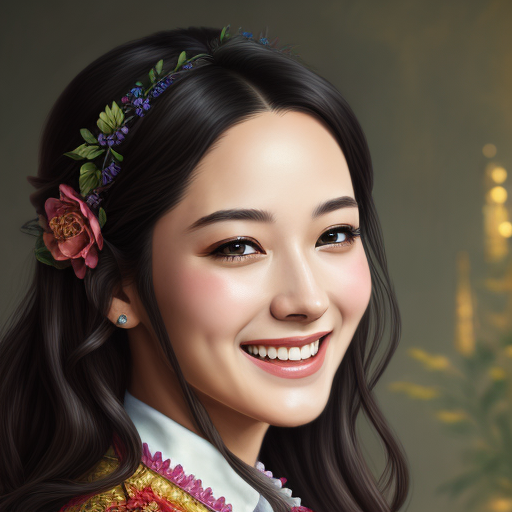

In [45]:
image = rotate_array(edited_face_imagenp, angle) if correct_tilt else edited_face_imagenp
Image.fromarray(image)

In [46]:
face_area_on_image = face.rotate_face_area_on_image(angle) if correct_tilt else face.face_area_on_image
face_area_on_image

(144, 95, 367, 416)

In [47]:
mask_generator = BiSeNetMaskGenerator()
m = mask_generator.generate_mask(edited_face_imagenp, face_area_on_image, **params)

In [48]:
m = rotate_array(m, -angle) if correct_tilt else m

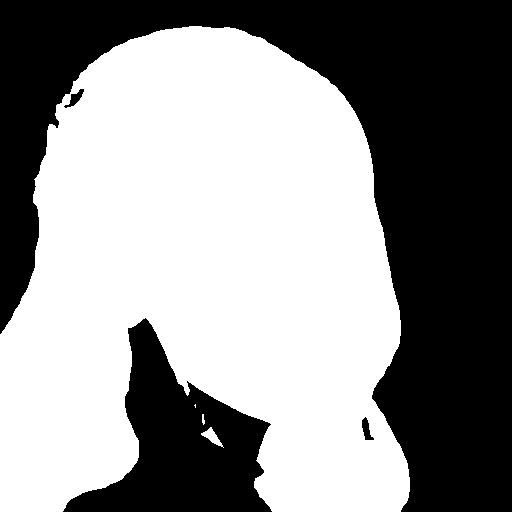

In [49]:
Image.fromarray(m)

In [50]:
edited_face_image_mask = m

In [51]:
edited_face_imagenp = cv2.resize(edited_face_imagenp, dsize=(face.width, face.height), interpolation=cv2.INTER_AREA)
edited_face_imagenp_mask = cv2.resize(edited_face_image_mask, dsize=(face.width, face.height), interpolation=cv2.INTER_AREA)

In [52]:
if option.apply_inside_mask_only:
    face_background = imagenp[
                        face.top : face.bottom,
                        face.left : face.right,
                    ]
    edited_face_fg = (edited_face_imagenp * (edited_face_imagenp_mask / 255.0)).astype("uint8")
    edited_face_bg = (face_background * (1 - (edited_face_imagenp_mask / 255.0))).astype("uint8")
    edited_face_imagenp = edited_face_fg + edited_face_bg

In [53]:
edited_imagenp = imagenp.copy()
edited_imagenp[
                face.top : face.bottom,
                face.left : face.right,
            ] = edited_face_imagenp
edited_imagenp_mask = np.zeros_like(edited_imagenp)
edited_imagenp_mask[
                face.top : face.bottom,
                face.left : face.right,
            ] = edited_face_imagenp_mask

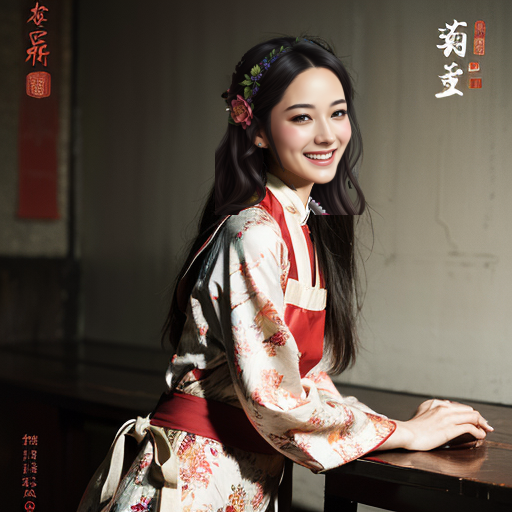

In [54]:
simple_composite_image = Image.fromarray(edited_imagenp)
simple_composite_image

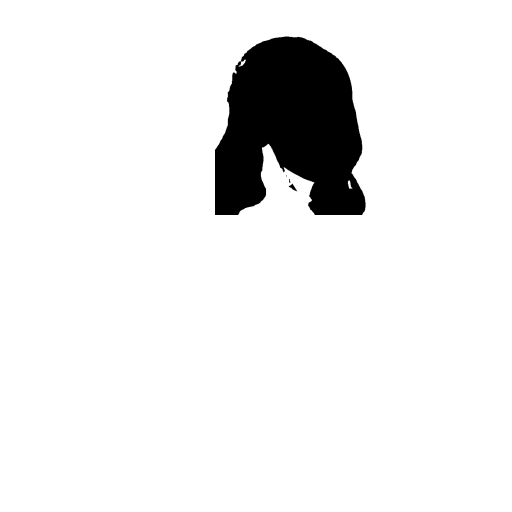

In [55]:
mask_image = Image.fromarray(255-edited_imagenp_mask)
mask_image

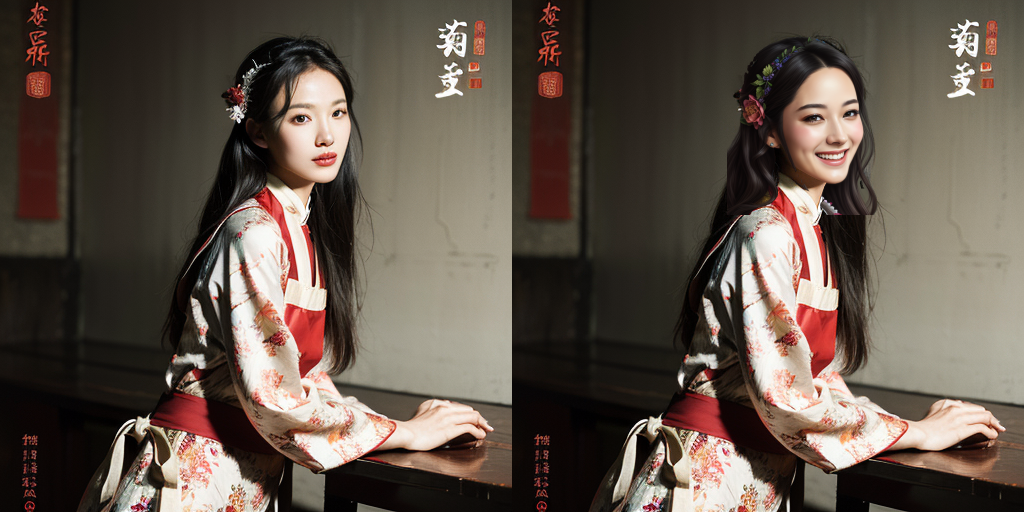

In [83]:
result = image_grid([image0, simple_composite_image], 1, 2)
result.save("assets/demo.png")
result

## Step 5. Blend the Entire Image (by Repainting the Background)

### Usually we do not need this step if we want to keep the original background

In [56]:
guidance_scale = 5
do_classifier_free_guidance = guidance_scale > 1.0
strength = 0.1
num_inference_steps = 50
batch_size = 2 if do_classifier_free_guidance else 1

prompt = "hyperdetailed, masterpiece, top quality, best quality, official art, beautiful and aesthetic, colorful,highest detailed"
negative_prompt = "bad_pictures,disfigured,lowres,cross-eyed,missing fingers,fused fingers,too many fingers,poorly drawn hands,malformed limbs,missing limb,mutated hands,ugly,long body,bad body,mutated,deformed,disconnected limbs,malformed hands,extra legs,bad feet,mutated hands and fingers,bad hands,extra limb,extra arms,floating limbs,poorly drawn face,skin blemishes,skin spots,mutation,long neck,mole,scar"

In [57]:
#hide
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained(f"{vae_model_path}")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(f"{base_model_path}", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
# scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.4.self_attn.out_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.pre_layrnorm.weight', 'visual_projection.weight', 'vision_model.encoder.layers.19.self_attn.k_proj.bias', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.2.mlp.fc2.bias', 'vision_model.encoder.layers.6.self_attn.q_proj.bias', 'vision_model.encoder.layers.1.layer_norm2.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.6.mlp.fc2.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.weight', 'vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.8.layer_norm1.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.layer_norm2.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.b

In [58]:
#hide
# To the GPU we go!
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device);

In [59]:
init_image = simple_composite_image

In [60]:
def create_binary_mask(image, round=True):
    if image.mode == 'RGBA' and image.getextrema()[-1] != (255, 255):
        if round:
            image = image.split()[-1].convert("L").point(lambda x: 255 if x > 128 else 0)
        else:
            image = image.split()[-1].convert("L")
    else:
        image = image.convert('L')
    return image

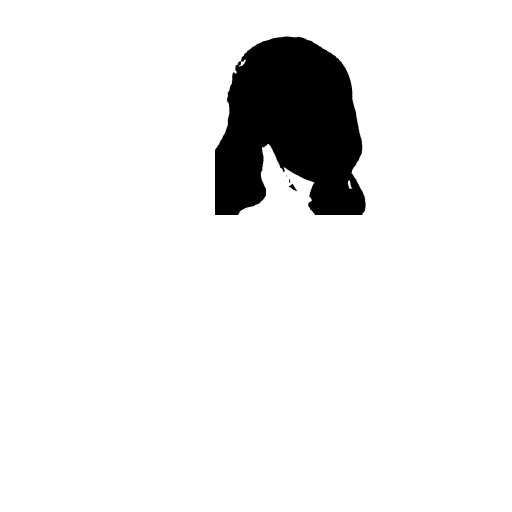

In [61]:
binary_mask = create_binary_mask(mask_image)
image_mask = binary_mask
binary_mask

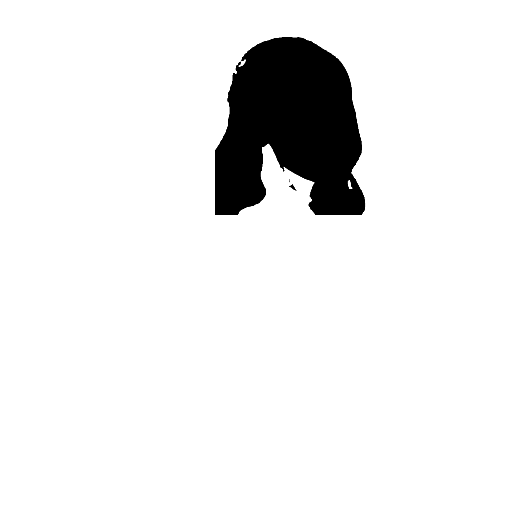

In [62]:
width, height = init_image.size
image_mask = resize_image(1, image_mask, width, height)
np_mask = np.array(image_mask)
np_mask = np.clip((np_mask.astype(np.float32)) * 2, 0, 255).astype(np.uint8)
mask_for_overlay = Image.fromarray(np_mask)
mask_for_overlay

In [63]:
overlay_images = []
latent_mask = image_mask

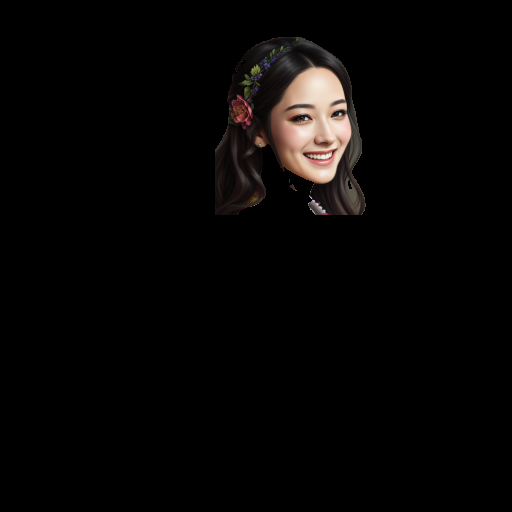

In [64]:
image_masked = Image.new('RGBa', (init_image.width, init_image.height))
image_masked.paste(init_image.convert("RGBA").convert("RGBa"), mask=ImageOps.invert(mask_for_overlay.convert('L')))
image_masked.show()

In [65]:
overlay_images.append(image_masked.convert('RGBA'))

In [66]:
init_image1 = np.array(init_image).astype(np.float32) / 255.0
init_image1 = np.moveaxis(init_image1, 2, 0)

In [67]:
batch_images = np.expand_dims(init_image1, axis=0).repeat(batch_size, axis=0)
init_image1 = torch.from_numpy(batch_images)
init_image1 = init_image1.to(device, dtype=torch.float16)
init_image1.shape

torch.Size([2, 3, 512, 512])

In [68]:
# from diffedit
generator = torch.cuda.manual_seed(seed)
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL.Image.Resampling.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0
def encode_image(init_image, latents_dtype, device, need_preprocess=True):
    # encode the init image into latents and scale the latents
    if need_preprocess:
        init_image = preprocess(init_image)
    init_image = init_image.to(device=device, dtype=latents_dtype)
    with torch.no_grad(): init_latent_dist = vae.encode(init_image).latent_dist
    init_latents = init_latent_dist.sample(generator=generator)
    init_latents = 0.18215 * init_latents #
    return init_latents

In [69]:
init_latent = encode_image(init_image, torch.float, device)
init_latent.shape

torch.Size([1, 4, 64, 64])

In [70]:
init_mask = latent_mask
latmask = init_mask.convert('RGB').resize((init_latent.shape[3], init_latent.shape[2]))
latmask = np.moveaxis(np.array(latmask, dtype=np.float32), 2, 0) / 255
latmask = latmask[0]
# if self.mask_round:
#     latmask = np.around(latmask)
latmask = np.tile(latmask[None], (4, 1, 1))

mask0 = torch.asarray(1.0 - latmask).to(device).type(torch.float16)
nmask0 = torch.asarray(latmask).to(device).type(torch.float16)

In [71]:
def inpainting_image_conditioning(source_image, latent_image, image_mask=None, round_image_mask=True):
    # self.is_using_inpainting_conditioning = True

    # Handle the different mask inputs
    if image_mask is not None:
        if torch.is_tensor(image_mask):
            conditioning_mask = image_mask
        else:
            conditioning_mask = np.array(image_mask.convert("L"))
            conditioning_mask = conditioning_mask.astype(np.float32) / 255.0
            conditioning_mask = torch.from_numpy(conditioning_mask[None, None])

            if round_image_mask:
                # Caller is requesting a discretized mask as input, so we round to either 1.0 or 0.0
                conditioning_mask = torch.round(conditioning_mask)

    else:
        conditioning_mask = source_image.new_ones(1, 1, *source_image.shape[-2:])

    # Create another latent image, this time with a masked version of the original input.
    # Smoothly interpolate between the masked and unmasked latent conditioning image using a parameter.
    conditioning_mask = conditioning_mask.to(device=source_image.device, dtype=source_image.dtype)
    conditioning_image = torch.lerp(
        source_image,
        source_image * (1.0 - conditioning_mask),
        # getattr(self, "inpainting_mask_weight", shared.opts.inpainting_mask_weight)
        0.5,
    )

    print(source_image.shape)
    print(conditioning_image.shape)

    # Encode the new masked image using first stage of network.
    # conditioning_image = self.sd_model.get_first_stage_encoding(self.sd_model.encode_first_stage(conditioning_image))
    conditioning_image = encode_image(conditioning_image, torch.float, device, need_preprocess=False)
    

    # Create the concatenated conditioning tensor to be fed to `c_concat`
    conditioning_mask = torch.nn.functional.interpolate(conditioning_mask, size=latent_image.shape[-2:])
    conditioning_mask = conditioning_mask.expand(conditioning_image.shape[0], -1, -1, -1)
    image_conditioning = torch.cat([conditioning_mask, conditioning_image], dim=1)
    image_conditioning = image_conditioning.to(device).type(torch.float16)

    return image_conditioning

In [72]:
image_conditioning = inpainting_image_conditioning(init_image1 * 2 - 1, init_latent, image_mask, round_image_mask=False)
image_conditioning.shape

torch.Size([2, 3, 512, 512])
torch.Size([2, 3, 512, 512])


torch.Size([2, 5, 64, 64])

In [73]:
def get_timestamps(scheduler, num_inference_steps, strength, device):
    scheduler.set_timesteps(num_inference_steps)

    # get the original timestep using init_timestep
    offset = scheduler.config.get("steps_offset", 0)
    init_timestep = int(num_inference_steps * strength) + offset
    init_timestep = min(init_timestep, num_inference_steps)

    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device=device)
    t_start = max(num_inference_steps - init_timestep + offset, 0)
    return timesteps, t_start

In [74]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
timesteps, t_start = get_timestamps(scheduler, num_inference_steps, strength, device)

In [75]:
# add noise to latents using the timesteps
noise = torch.randn(init_latent.shape, generator=generator, device=device, dtype=torch.float16)
noisy_latents = scheduler.add_noise(init_latent, noise, timesteps)
latents = noisy_latents

In [76]:
timesteps = scheduler.timesteps[t_start:].to(device)
noise_preds = torch.tensor([], device='cuda')

In [77]:
def get_text_embeddings(prompt, negative_prompt, tokenizer, text_encoder, do_classifier_free_guidance, device): #outputs text_embeddings
    # get prompt text embeddings
    text_inputs = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, 
                            return_tensors="pt", truncation=True)
    text_input_ids = text_inputs.input_ids
    text_embeddings = text_encoder(text_input_ids.to(device))[0]
    # text_embeddings = text_embeddings.repeat_interleave(num_images_per_prompt, dim=0)
    
    if negative_prompt is None:
        uncond_tokens = [""]
    else:
        uncond_tokens = negative_prompt
    max_length = text_input_ids.shape[-1]
    uncond_input = tokenizer(uncond_tokens, padding="max_length", max_length=max_length, 
                             return_tensors="pt", truncation=True)
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # duplicate unconditional embeddings for each generation per prompt
    # uncond_embeddings = uncond_embeddings.repeat_interleave(batch_size * num_images_per_prompt, dim=0)
    
    # For classifier free guidance, we need to do two forward passes.
    # Here we concatenate the unconditional and text embeddings into a single batch
    # to avoid doing two forward passes
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings

In [78]:
text_embeddings = get_text_embeddings(prompt, negative_prompt, tokenizer, text_encoder, do_classifier_free_guidance, device)
for i, t in enumerate(timesteps):
    # expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # print(latent_model_input.shape, image_conditioning.shape)
    
    # latent_model_input = torch.cat([latent_model_input, image_conditioning], dim=1)
    
    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    if do_classifier_free_guidance:
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
    noise_preds = torch.concat((noise_preds, noise_pred)) #This performs much worse when outside the for-loop
    # compute the previous noisy sample x_t -> x_t-1
    latent_step = scheduler.step(noise_pred, t, latents)
    latents = latent_step.prev_sample 
    if mask0 is not None: 
        # latents = mask*latents+(1-mask)*init_latent
        latents = latents*nmask0 + init_latent*mask0

In [79]:
latents = 1 / 0.18215 * latents
with torch.no_grad(): image = vae.decode(latents).sample

In [80]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

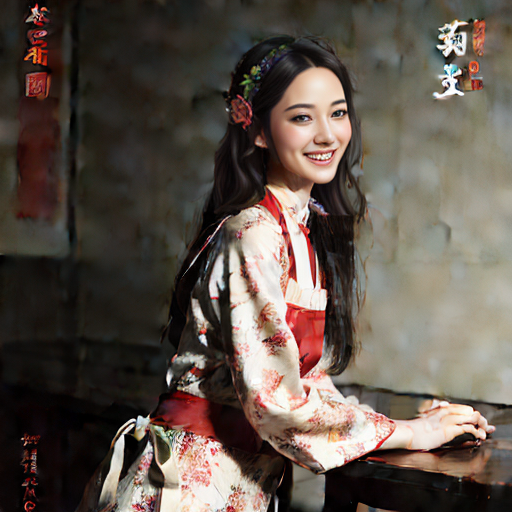

In [81]:
image_grid(pil_images, 1, len(pil_images))